In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import sklearn.linear_model
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
import keras
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import pydot 
import graphviz

In [129]:
raw_df = pd.read_csv("data/Venice_May1819.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 103560 Airbnb listings


,date,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count
0,5/1/18,4302018,21129007,Aeroporto,45.512592,12.344955,Private room,50,1,2
1,5/1/18,4691319,21129007,Aeroporto,45.514682,12.343570,Private room,75,1,2
2,5/1/18,12984761,61055442,Aeroporto,45.514338,12.343919,Private room,75,1,1


In [130]:
raw_df.dtypes

date                               object
id                                  int64
host_id                             int64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
calculated_host_listings_count      int64
dtype: object

In [131]:
raw_df.date = pd.to_datetime(raw_df.date) 
raw_df=raw_df.dropna()

In [132]:
# raw_df=raw_df.drop(['Column1'], axis=1)
raw_df.head()

,date,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count
0,2018-05-01,4302018,21129007,Aeroporto,45.512592,12.344955,Private room,50,1,2
1,2018-05-01,4691319,21129007,Aeroporto,45.514682,12.343570,Private room,75,1,2
2,2018-05-01,12984761,61055442,Aeroporto,45.514338,12.343919,Private room,75,1,1
3,2018-05-01,17005663,110584405,Aeroporto,45.502054,12.331291,Private room,90,1,3
4,2018-05-01,21430735,110584405,Aeroporto,45.501522,12.329316,Private room,80,1,3


In [133]:
raw_df.isna().sum()


date                              0
id                                0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

In [134]:
raw_df.price.value_counts()

100     5503
120     5340
150     3930
80      3748
90      3470
        ... 
536        1
6990       1
456        1
1990       1
990        1
Name: price, Length: 468, dtype: int64

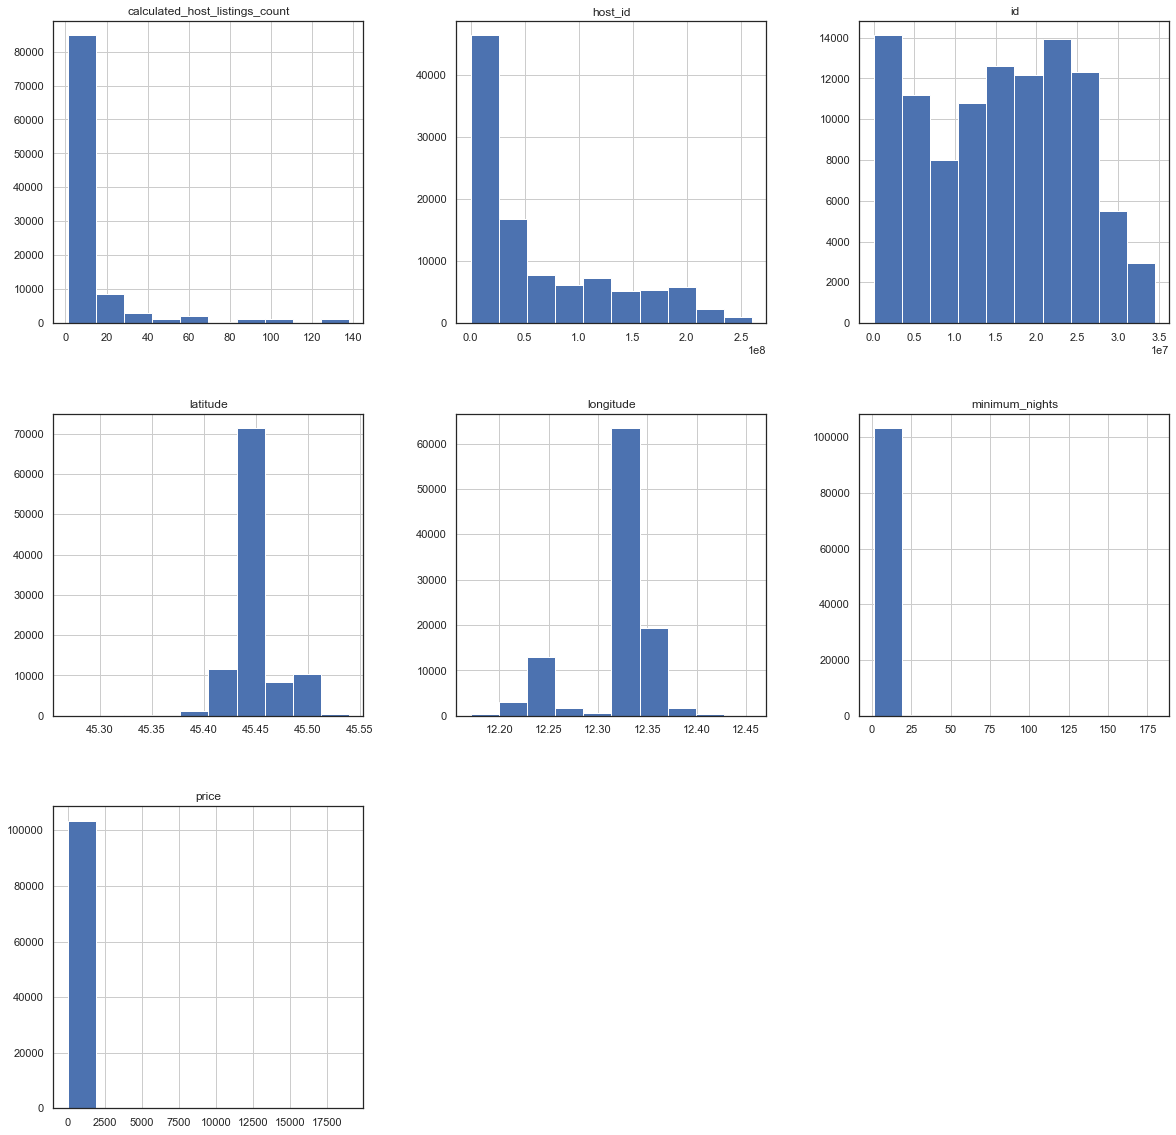

In [135]:
# Replacing columns with f/t with 0/1
raw_df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
raw_df.hist(figsize=(20,20));

In [136]:
raw_df.room_type.value_counts()


Entire home/apt    79113
Private room       23357
Shared room         1090
Name: room_type, dtype: int64

In [137]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(raw_df.set_index('date').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
date
2018-01-01    134.25
2019-01-01    135.00
Freq: AS-JAN, Name: price, dtype: float64


In [138]:
host_listings_count = raw_df.host_id.value_counts()
host_listings_count

289615       1451
2634978      1325
14357135     1164
669047        818
10189388      805
             ... 
225412581       1
258235699       1
259575135       1
256689915       1
225478511       1
Name: host_id, Length: 4784, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


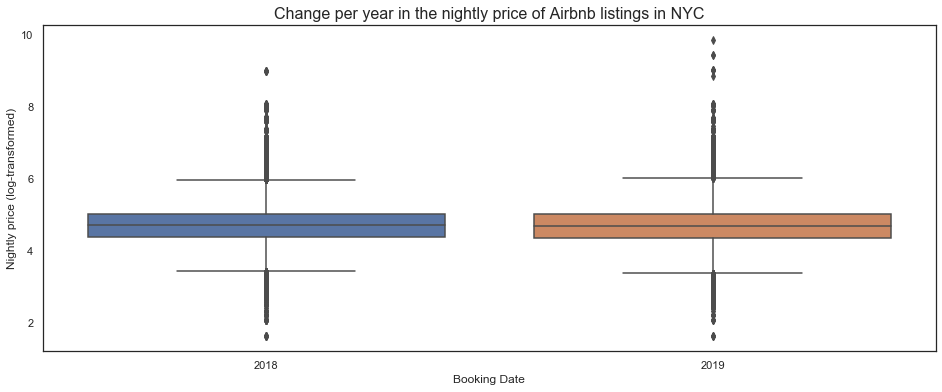

In [139]:
plt.figure(figsize=(16,6))
sns.boxplot(raw_df.date.dt.year, np.log(raw_df.price))
plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [140]:
raw_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,calculated_host_listings_count
count,1.035600e+05,1.035600e+05,103560.000000,103560.000000,103560.000000,103560.000000,103560.000000
mean,1.542861e+07,6.198067e+07,45.445435,12.319158,134.548030,2.189755,11.170201
std,9.081895e+06,6.621716e+07,0.022947,0.040415,166.194489,2.138030,22.433449
min,1.632000e+03,1.801000e+03,45.268735,12.170909,0.000000,1.000000,1.000000
25%,7.236712e+06,9.017175e+06,45.434034,12.322625,79.000000,1.000000,1.000000
50%,1.609109e+07,3.163455e+07,45.438204,12.330937,110.000000,2.000000,3.000000
75%,2.306881e+07,1.049950e+08,45.444879,12.339970,150.000000,3.000000,8.000000
max,3.459381e+07,2.605547e+08,45.540014,12.456410,19000.000000,180.000000,138.000000


In [141]:
print(f"Nightly advertised prices range from ${min(raw_df.price)} to ${max(raw_df.price)}.")


Nightly advertised prices range from $0 to $19000.


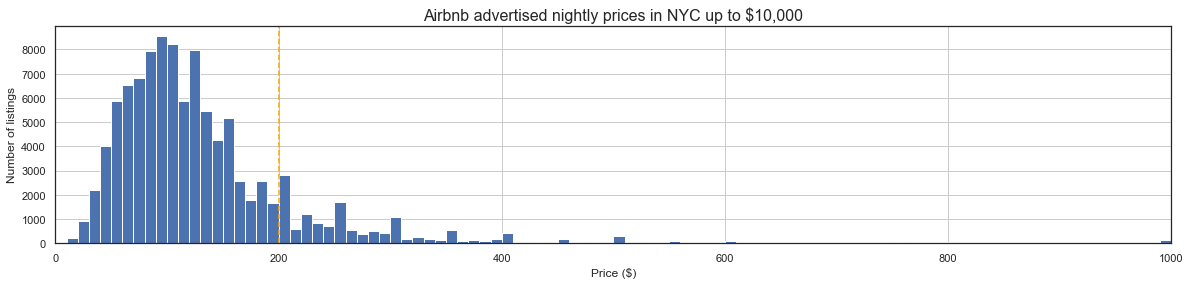

In [142]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.savefig('images/NYC_nightly prices.png')
plt.show()

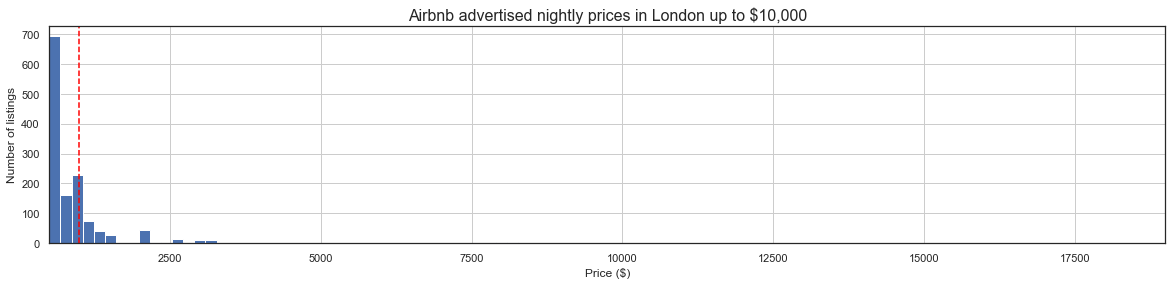

In [143]:
# Distribution of prices from $500 upwards
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(500, max(raw_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [144]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    raw_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

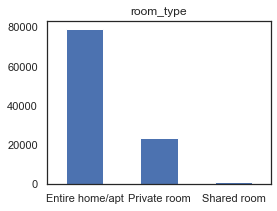

Entire home/apt    0.763934
Private room       0.225541
Shared room        0.010525
Name: room_type, dtype: float64


In [145]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(raw_df[col].value_counts(normalize=True))

In [146]:
transformed_df = pd.get_dummies(raw_df)
transformed_df.head()

,date,id,host_id,latitude,longitude,...,neighbourhood_Zelarino,neighbourhood_Zona Commerciale via Torino,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2018-05-01,4302018,21129007,45.512592,12.344955,...,0,0,0,1,0
1,2018-05-01,4691319,21129007,45.514682,12.343570,...,0,0,0,1,0
2,2018-05-01,12984761,61055442,45.514338,12.343919,...,0,0,0,1,0
3,2018-05-01,17005663,110584405,45.502054,12.331291,...,0,0,0,1,0
4,2018-05-01,21430735,110584405,45.501522,12.329316,...,0,0,0,1,0


In [147]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

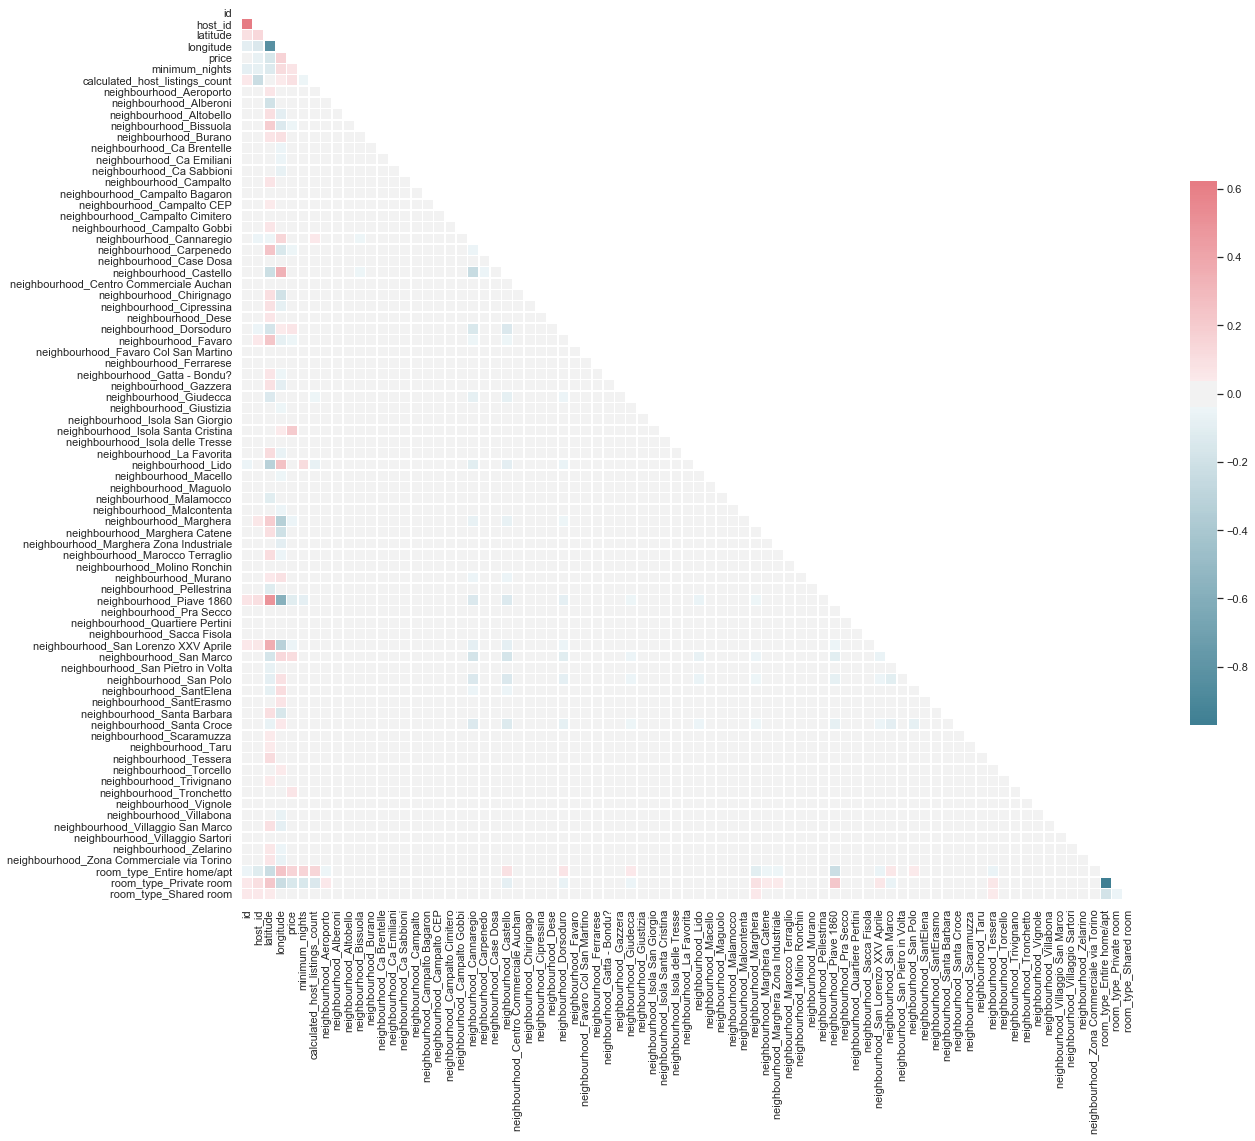

In [148]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

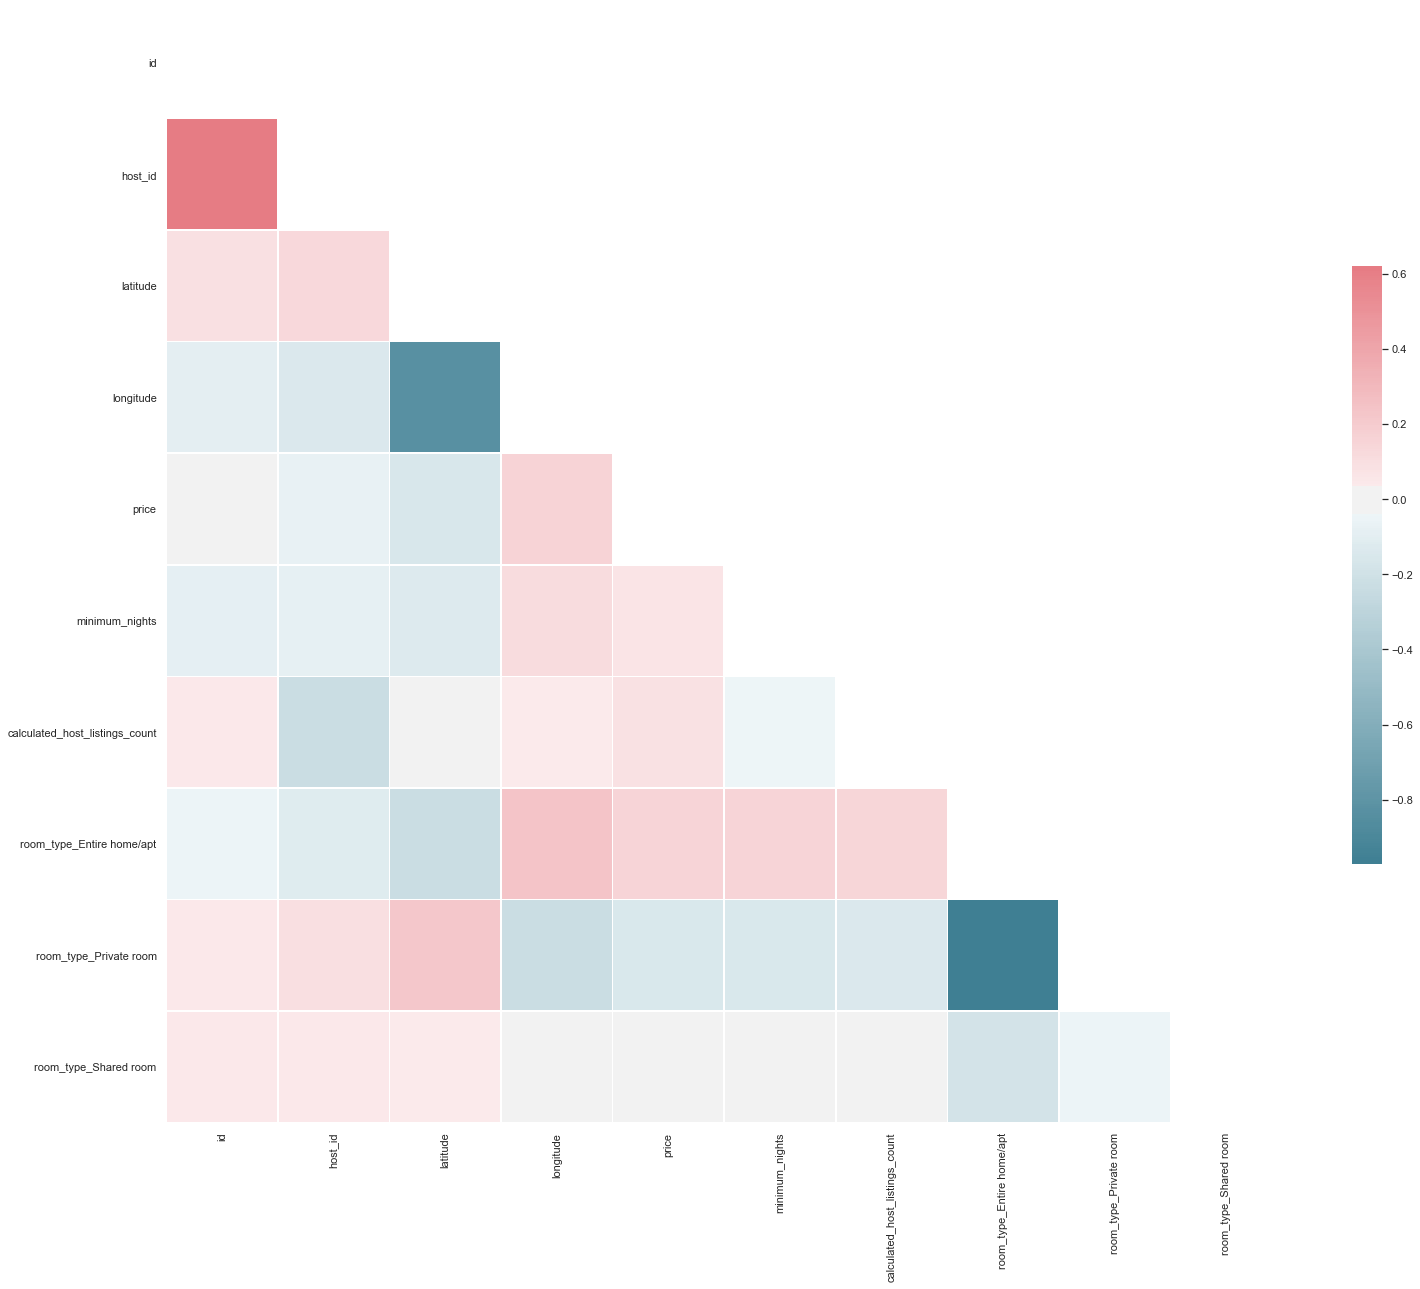

In [149]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

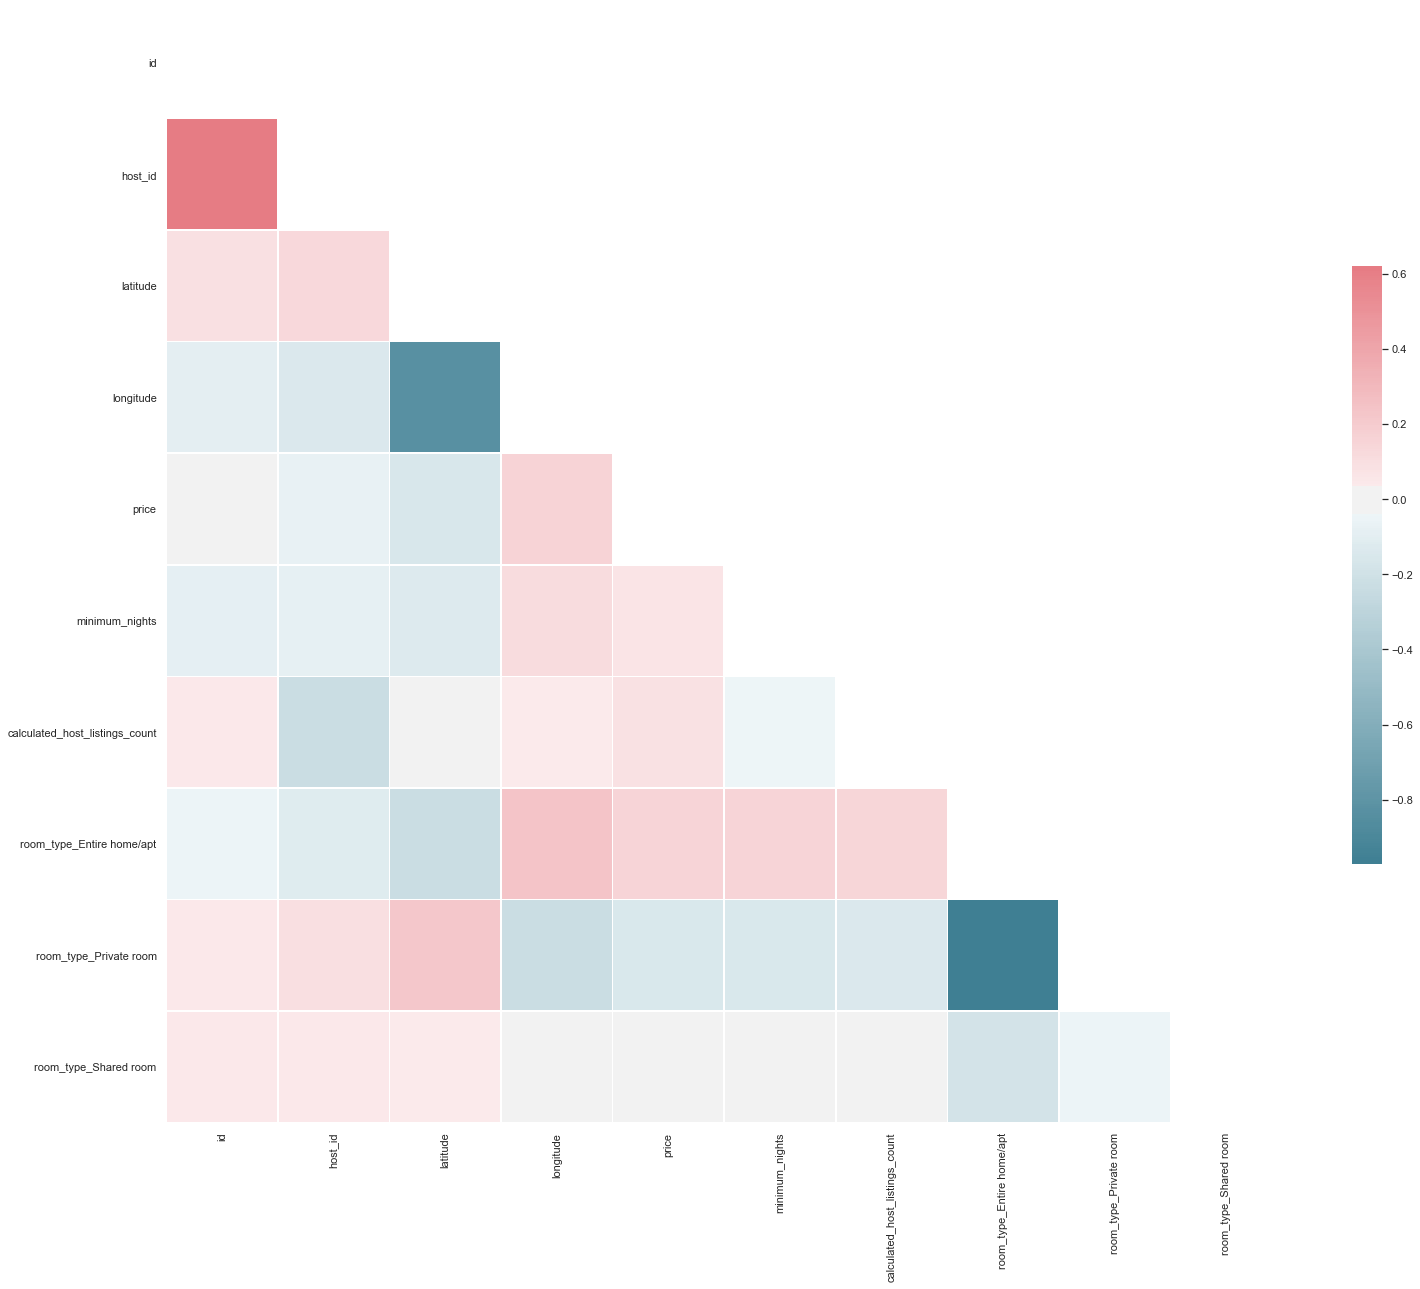

In [150]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [151]:
numerical_columns = ['price', 'id', 'calculated_host_listings_count', 'minimum_nights', 'latitude', 'longitude']


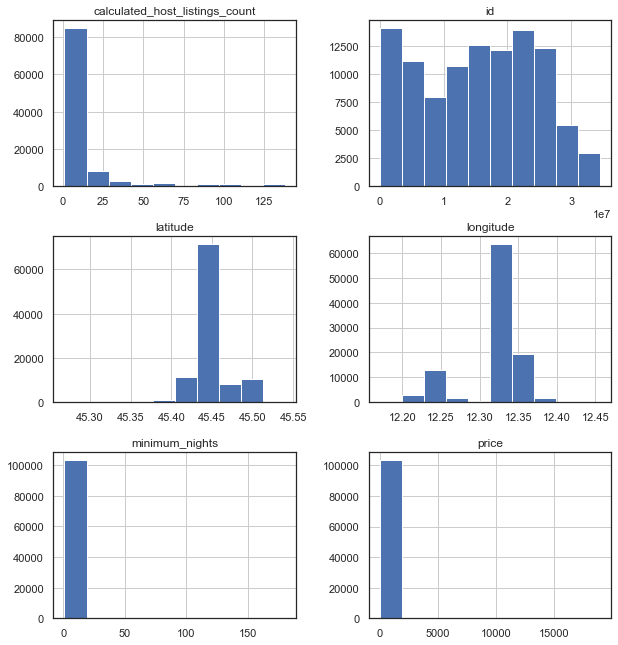

In [152]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [153]:
transformed_df['date'] = pd.to_datetime(transformed_df['date'])
transformed_df['day_of_week'] = transformed_df['date'].dt.day_name().map({"Monday":0, "Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6})

In [154]:
transformed_df.head()

,date,id,host_id,latitude,longitude,...,neighbourhood_Zona Commerciale via Torino,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,day_of_week
0,2018-05-01,4302018,21129007,45.512592,12.344955,...,0,0,1,0,1
1,2018-05-01,4691319,21129007,45.514682,12.343570,...,0,0,1,0,1
2,2018-05-01,12984761,61055442,45.514338,12.343919,...,0,0,1,0,1
3,2018-05-01,17005663,110584405,45.502054,12.331291,...,0,0,1,0,1
4,2018-05-01,21430735,110584405,45.501522,12.329316,...,0,0,1,0,1


In [155]:
transformed_df["new_year_day"] = transformed_df['date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_df['day_of_the_year'] = transformed_df.apply(lambda x: (x['date'] - x['new_year_day']).days + 1, axis=1)

In [156]:
transformed_df.tail(40)

,date,id,host_id,latitude,longitude,...,room_type_Private room,room_type_Shared room,day_of_week,new_year_day,day_of_the_year
103520,2019-03-01,11037556,57257277,45.48650,12.24991,...,0,0,4,2019-01-01,60
103521,2019-03-01,12370219,30294624,45.48125,12.25583,...,0,0,4,2019-01-01,60
103522,2019-03-01,13940818,8264779,45.48462,12.24774,...,0,0,4,2019-01-01,60
103523,2019-03-01,14678329,56306502,45.48023,12.25124,...,0,0,4,2019-01-01,60
103524,2019-03-01,17454741,57257277,45.48608,12.25154,...,0,0,4,2019-01-01,60
103525,2019-03-01,22478710,164808735,45.48299,12.25437,...,0,0,4,2019-01-01,60
103526,2019-03-01,23068807,170924538,45.48177,12.25565,...,0,0,4,2019-01-01,60
103527,2019-03-01,26002249,173779768,45.48327,12.24454,...,0,0,4,2019-01-01,60
103528,2019-03-01,26017795,19120945,45.48338,12.24457,...,0,0,4,2019-01-01,60
103529,2019-03-01,27671748,208851053,45.48535,12.25140,...,0,0,4,2019-01-01,60


In [157]:
transformed_df['Year'] = transformed_df.new_year_day.astype(str).str[:4]
transformed_df['Year'] = transformed_df['Year'].astype(int)
transformed_df.tail()

,date,id,host_id,latitude,longitude,...,room_type_Shared room,day_of_week,new_year_day,day_of_the_year,Year
103555,2019-05-01,26017795,19120945,45.48338,12.24457,...,0,2,2019-01-01,121,2019
103556,2019-05-01,27671748,208851053,45.48535,12.25140,...,0,2,2019-01-01,121,2019
103557,2019-05-01,30395113,14357135,45.48227,12.25422,...,0,2,2019-01-01,121,2019
103558,2019-05-01,32239369,170924538,45.48130,12.25565,...,0,2,2019-01-01,121,2019
103559,2019-05-01,33153615,182397277,45.48091,12.24011,...,0,2,2019-01-01,121,2019


In [158]:
del transformed_df['date']
del transformed_df['new_year_day']
transformed_df.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_week,day_of_the_year,Year
0,4302018,21129007,45.512592,12.344955,50,...,1,0,1,121,2018
1,4691319,21129007,45.514682,12.343570,75,...,1,0,1,121,2018
2,12984761,61055442,45.514338,12.343919,75,...,1,0,1,121,2018
3,17005663,110584405,45.502054,12.331291,90,...,1,0,1,121,2018
4,21430735,110584405,45.501522,12.329316,80,...,1,0,1,121,2018


# Machine Learning

In [159]:
# Separating X and y
X = transformed_df
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [160]:
X.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_week,day_of_the_year,Year
0,-1.225146,-0.616938,2.926608,0.638321,-0.508732,...,1.853048,-0.103137,-0.958904,-0.408679,-0.81584
1,-1.182280,-0.616938,3.017654,0.604045,-0.358305,...,1.853048,-0.103137,-0.958904,-0.408679,-0.81584
2,-0.269091,-0.013973,3.002672,0.612679,-0.358305,...,1.853048,-0.103137,-0.958904,-0.408679,-0.81584
3,0.173649,0.734009,2.467368,0.300223,-0.268049,...,1.853048,-0.103137,-0.958904,-0.408679,-0.81584
4,0.660892,0.734009,2.444198,0.251348,-0.328220,...,1.853048,-0.103137,-0.958904,-0.408679,-0.81584


In [161]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Training Models

In [162]:
# MOST SUCCESSFUL MODEL
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.0409
Validation MSE: 0.049

Training r2: 1.0
Validation r2: 1.0


In [163]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.tail()

,weight
neighbourhood_San Polo,0.000098
minimum_nights,0.000125
latitude,0.004302
id,0.020281
price,0.974980


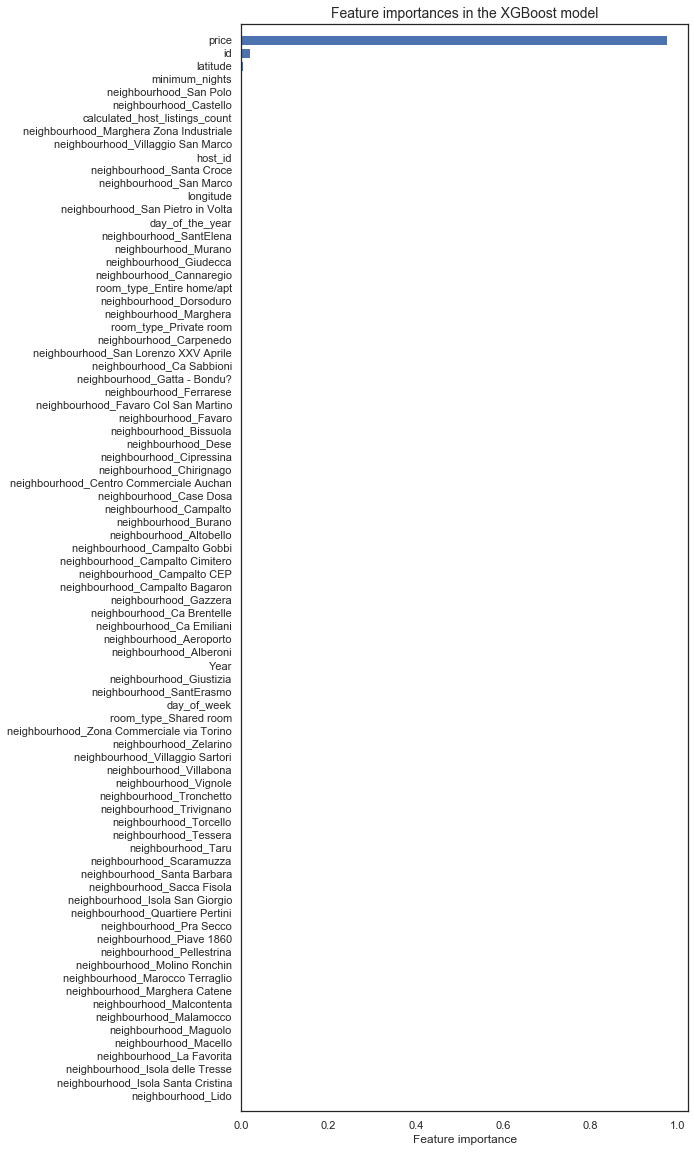

In [164]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [165]:
print("Median number of listings per host:", int(raw_df.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(raw_df.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(raw_df[raw_df.calculated_host_listings_count == 1])/len(raw_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 3
Mean number of listings per host: 11
32% of listings are from hosts with one listing.


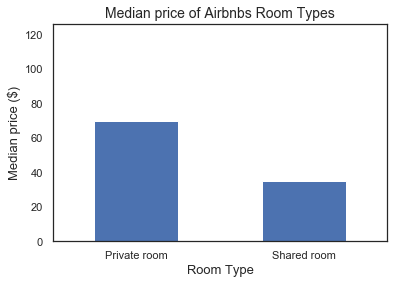

In [166]:
raw_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs Room Types', fontsize=14)
plt.xlabel('Room Type', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

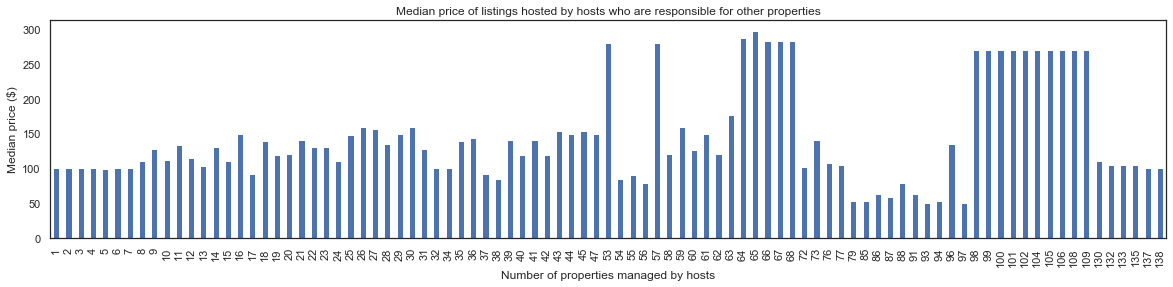

In [167]:
# Median price for different host listing counts
plt.figure()
raw_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');

In [168]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               10624     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 109,697
Trainable params: 109,697
Non-trainable params: 0
_________________________________________________________________
None


In [169]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/15
292/292 [==============================] - 1s 2ms/step - loss: 15597.0752 - mean_squared_error: 15597.0752 - val_loss: 611.4152 - val_mean_squared_error: 611.4152
Epoch 2/15
292/292 [==============================] - 1s 2ms/step - loss: 358.6741 - mean_squared_error: 358.6741 - val_loss: 189.6327 - val_mean_squared_error: 189.6327
Epoch 3/15
292/292 [==============================] - 1s 2ms/step - loss: 110.1492 - mean_squared_error: 110.1492 - val_loss: 98.4176 - val_mean_squared_error: 98.4176
Epoch 4/15
292/292 [==============================] - 1s 2ms/step - loss: 63.8689 - mean_squared_error: 63.8689 - val_loss: 66.4021 - val_mean_squared_error: 66.4021
Epoch 5/15
292/292 [==============================] - 1s 2ms/step - loss: 51.9138 - mean_squared_error: 51.9138 - val_loss: 79.3934 - val_mean_squared_error: 79.3934
Epoch 6/15
292/292 [==============================] - 1s 2ms/step - loss: 49.3761 - mean_squared_error: 49.3761 - val_loss: 78.2454 - val_mean_squared_error

In [170]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
#     # Line graph of losses
#     model_results = model.history.history
#     plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
#     plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
#     plt.legend()
#     plt.title('Training and test loss at each epoch', fontsize=14)
#     plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 18.0995
Validation MSE: 16.1651

Training r2: 0.9993
Validation r2: 0.9994


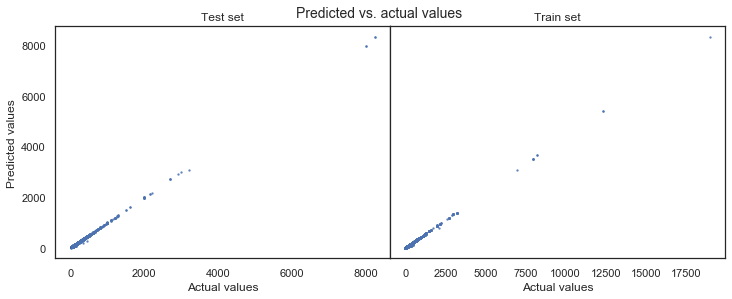

In [171]:
nn_model_evaluation(nn2)


In [172]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               10624     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 241,537
Trainable params: 241,537
Non-trainable params: 0
_________________________________________________________________
None


In [173]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


Epoch 1/15
292/292 [==============================] - 1s 4ms/step - loss: 6691.6729 - mean_squared_error: 6636.1978 - val_loss: 299.5347 - val_mean_squared_error: 248.1931
Epoch 2/15
292/292 [==============================] - 1s 4ms/step - loss: 313.1214 - mean_squared_error: 263.6168 - val_loss: 196.0665 - val_mean_squared_error: 148.0795
Epoch 3/15
292/292 [==============================] - 1s 4ms/step - loss: 240.4885 - mean_squared_error: 193.5389 - val_loss: 131.1705 - val_mean_squared_error: 85.1025
Epoch 4/15
292/292 [==============================] - 1s 4ms/step - loss: 97.9050 - mean_squared_error: 52.5844 - val_loss: 247.4597 - val_mean_squared_error: 202.6214
Epoch 5/15
292/292 [==============================] - 1s 4ms/step - loss: 118.1796 - mean_squared_error: 73.7611 - val_loss: 187.9275 - val_mean_squared_error: 144.0185
Epoch 6/15
292/292 [==============================] - 1s 4ms/step - loss: 301.0044 - mean_squared_error: 257.2502 - val_loss: 263.0367 - val_mean_square

Training MSE: 68.1943
Validation MSE: 60.5792

Training r2: 0.9975
Validation r2: 0.9978


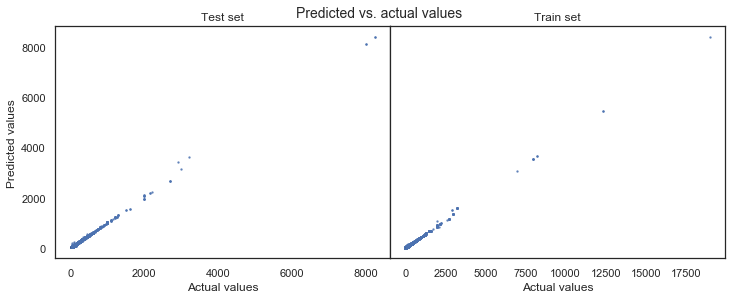

In [174]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

In [175]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               10624     
_________________________________________________________________
dense_32 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 513       
Total params: 241,537
Trainable params: 241,537
Non-trainable params: 0
_________________________________________________________________
None


In [176]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.0409
Validation MSE: 0.049

Training r2: 1.0
Validation r2: 1.0


In [177]:
# nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

In [178]:
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 82)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               10624     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)             

In [179]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

Epoch 1/15
292/292 [==============================] - 1s 4ms/step - loss: 21969.0723 - mean_squared_error: 21969.0723 - val_loss: 11441.7480 - val_mean_squared_error: 11441.7480
Epoch 2/15
292/292 [==============================] - 1s 4ms/step - loss: 15494.7754 - mean_squared_error: 15494.7754 - val_loss: 8231.8535 - val_mean_squared_error: 8231.8535
Epoch 3/15
292/292 [==============================] - 1s 4ms/step - loss: 11612.1562 - mean_squared_error: 11612.1562 - val_loss: 6330.8955 - val_mean_squared_error: 6330.8955
Epoch 4/15
292/292 [==============================] - 1s 4ms/step - loss: 10955.4688 - mean_squared_error: 10955.4688 - val_loss: 6245.9922 - val_mean_squared_error: 6245.9922
Epoch 5/15
292/292 [==============================] - 1s 4ms/step - loss: 13234.2773 - mean_squared_error: 13234.2773 - val_loss: 5425.5361 - val_mean_squared_error: 5425.5361
Epoch 6/15
292/292 [==============================] - 1s 4ms/step - loss: 18086.3242 - mean_squared_error: 18086.3242 

Training MSE: 7141.6977
Validation MSE: 7030.2617

Training r2: 0.7428
Validation r2: 0.7399


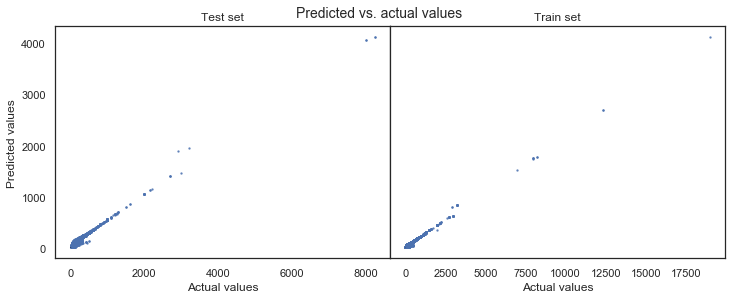

In [180]:
nn_model_evaluation(nn5, skip_epochs=2)

In [181]:
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_12 (Dropout)         (None, 82)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               10624     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)             

In [182]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

Epoch 1/15
146/146 [==============================] - 1s 7ms/step - loss: 17758.3301 - mean_squared_error: 17758.3301 - val_loss: 2173.8828 - val_mean_squared_error: 2173.8828
Epoch 2/15
146/146 [==============================] - 1s 7ms/step - loss: 10269.4111 - mean_squared_error: 10269.4111 - val_loss: 1834.3904 - val_mean_squared_error: 1834.3904
Epoch 3/15
146/146 [==============================] - 1s 7ms/step - loss: 5981.0708 - mean_squared_error: 5981.0708 - val_loss: 1571.1331 - val_mean_squared_error: 1571.1331
Epoch 4/15
146/146 [==============================] - 1s 7ms/step - loss: 6389.6465 - mean_squared_error: 6389.6465 - val_loss: 1173.1595 - val_mean_squared_error: 1173.1595
Epoch 5/15
146/146 [==============================] - 1s 6ms/step - loss: 6750.7720 - mean_squared_error: 6750.7720 - val_loss: 1570.4449 - val_mean_squared_error: 1570.4449
Epoch 6/15
146/146 [==============================] - 1s 6ms/step - loss: 9434.5049 - mean_squared_error: 9434.5049 - val_loss

Training MSE: 1121.3172
Validation MSE: 1105.4941

Training r2: 0.9596
Validation r2: 0.9591


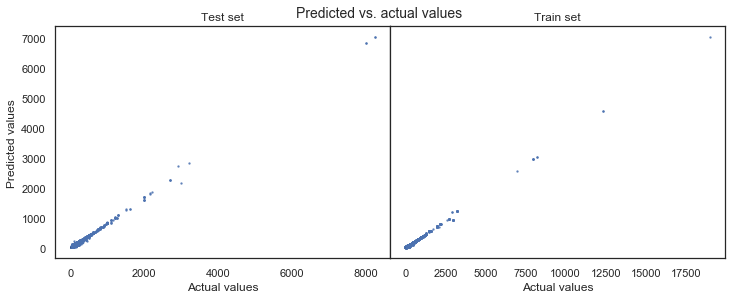

In [183]:
nn_model_evaluation(nn6)

## Testing Models

The most successful model was the XGBoost Regression model.

In [224]:
test_dataset = pd.read_csv("data/Venice_June1920.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 103560 Airbnb listings


,date,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count
0,2018-05-01,4302018,21129007,Aeroporto,45.512592,12.344955,Private room,50,1,2
1,2018-05-01,4691319,21129007,Aeroporto,45.514682,12.343570,Private room,75,1,2
2,2018-05-01,12984761,61055442,Aeroporto,45.514338,12.343919,Private room,75,1,1


In [225]:
test_dataset.date = pd.to_datetime(test_dataset.date) 
test_dataset=test_dataset.dropna()

In [226]:
test_dataset.isna().sum()

date                              0
id                                0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

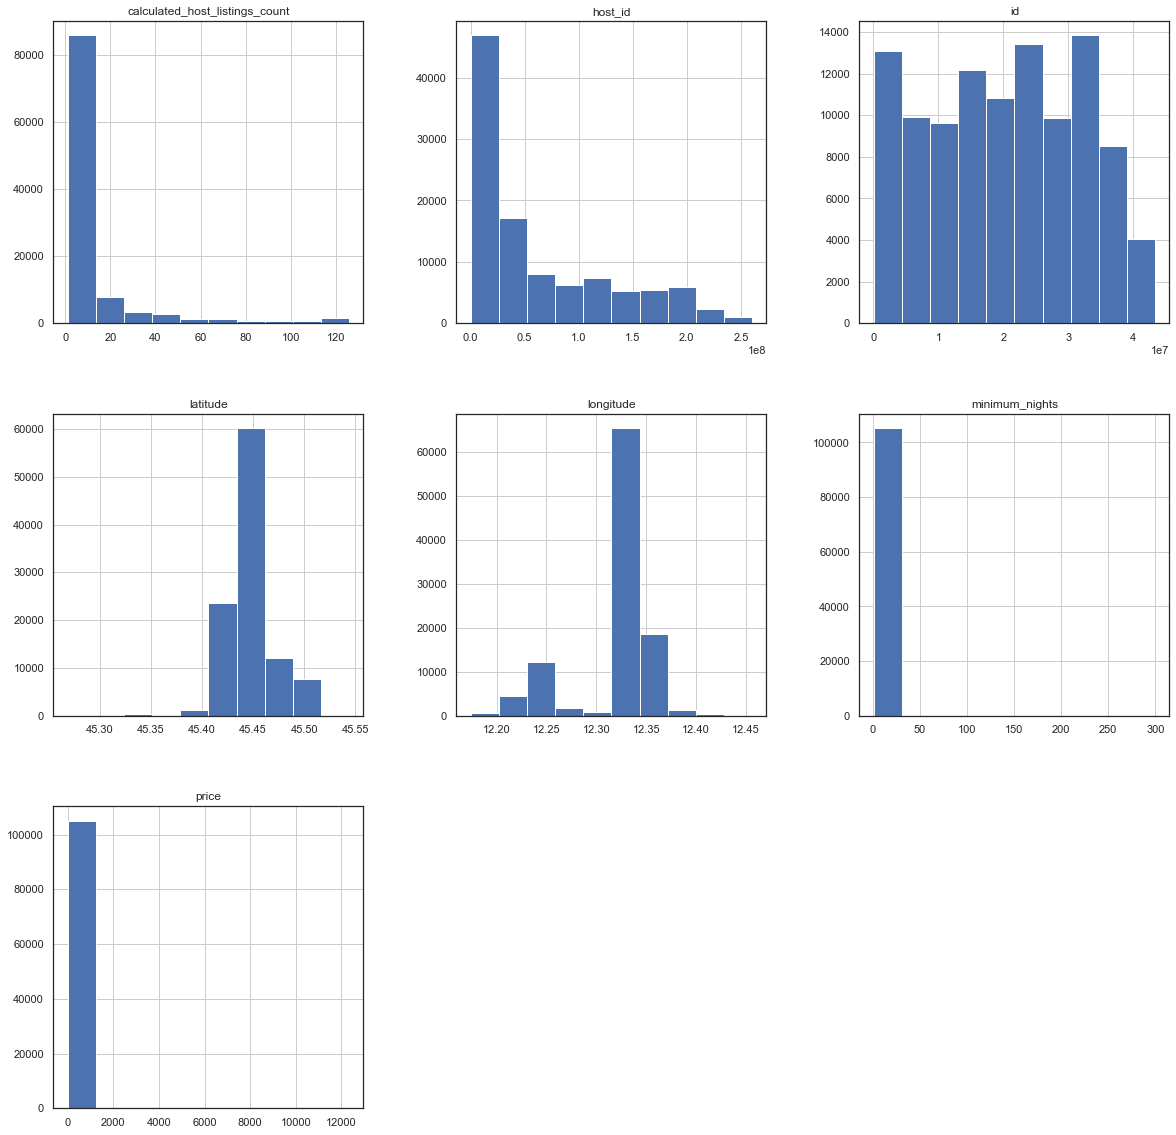

In [227]:
# Replacing columns with f/t with 0/1
test_dataset.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
test_dataset.hist(figsize=(20,20));

In [228]:
transformed_test = pd.get_dummies(test_dataset)
transformed_test.head()

,date,id,host_id,latitude,longitude,...,neighbourhood_Zona Commerciale via Torino,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,2019-06-01,4302018,21129007,45.51259,12.34496,...,0,0,0,1,0
1,2019-06-01,4691319,61055442,45.51468,12.34357,...,0,0,0,1,0
2,2019-06-01,12984761,110584405,45.51434,12.34392,...,0,0,0,1,0
3,2019-06-01,17005663,110584405,45.50205,12.33129,...,0,0,0,1,0
4,2019-06-01,21430735,110584405,45.50152,12.32932,...,0,0,0,1,0


In [229]:
transformed_test.dtypes

date                                         datetime64[ns]
id                                                    int64
host_id                                               int64
latitude                                            float64
longitude                                           float64
price                                                 int64
minimum_nights                                        int64
calculated_host_listings_count                        int64
neighbourhood_Aeroporto                               uint8
neighbourhood_Alberoni                                uint8
neighbourhood_Altobello                               uint8
neighbourhood_Asseggiano                              uint8
neighbourhood_Bissuola                                uint8
neighbourhood_Burano                                  uint8
neighbourhood_Ca Brentelle                            uint8
neighbourhood_Ca Emiliani                             uint8
neighbourhood_Ca Sabbioni               

In [230]:
transformed_test["new_year_day"] = transformed_test['date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_test['day_of_the_year'] = transformed_test.apply(lambda x: (x['date'] - x['new_year_day']).days + 1, axis=1)

In [231]:
transformed_test['date'] = pd.to_datetime(transformed_test['date'])
transformed_test['day_of_week'] = transformed_test['date'].dt.day_name().map({"Monday":0, "Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6})

In [232]:
transformed_test['Year'] = transformed_test.new_year_day.astype(str).str[:4]
transformed_test['Year'] = transformed_test['Year'].astype(int)
transformed_test.tail()

,date,id,host_id,latitude,longitude,...,room_type_Shared room,new_year_day,day_of_the_year,day_of_week,Year
105316,2020-05-01,27671748,102043955,45.48535,12.25140,...,0,2020-01-01,122,4,2020
105317,2020-05-01,30395113,188656407,45.48227,12.25422,...,0,2020-01-01,122,4,2020
105318,2020-05-01,31016632,610142,45.48222,12.25287,...,0,2020-01-01,122,4,2020
105319,2020-05-01,33153615,4496256,45.48091,12.24011,...,0,2020-01-01,122,4,2020
105320,2020-05-01,41552272,16841762,45.48084,12.25588,...,0,2020-01-01,122,4,2020


In [233]:
# del transformed_test['Unnamed: 0']
transformed_test.head()

,date,id,host_id,latitude,longitude,...,room_type_Shared room,new_year_day,day_of_the_year,day_of_week,Year
0,2019-06-01,4302018,21129007,45.51259,12.34496,...,0,2019-01-01,152,5,2019
1,2019-06-01,4691319,61055442,45.51468,12.34357,...,0,2019-01-01,152,5,2019
2,2019-06-01,12984761,110584405,45.51434,12.34392,...,0,2019-01-01,152,5,2019
3,2019-06-01,17005663,110584405,45.50205,12.33129,...,0,2019-01-01,152,5,2019
4,2019-06-01,21430735,110584405,45.50152,12.32932,...,0,2019-01-01,152,5,2019


In [234]:
transformed_test=transformed_test.drop(['new_year_day'], axis=1)
transformed_test.head()

,date,id,host_id,latitude,longitude,...,room_type_Private room,room_type_Shared room,day_of_the_year,day_of_week,Year
0,2019-06-01,4302018,21129007,45.51259,12.34496,...,1,0,152,5,2019
1,2019-06-01,4691319,61055442,45.51468,12.34357,...,1,0,152,5,2019
2,2019-06-01,12984761,110584405,45.51434,12.34392,...,1,0,152,5,2019
3,2019-06-01,17005663,110584405,45.50205,12.33129,...,1,0,152,5,2019
4,2019-06-01,21430735,110584405,45.50152,12.32932,...,1,0,152,5,2019


In [235]:
del transformed_test['date']
transformed_test.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_the_year,day_of_week,Year
0,4302018,21129007,45.51259,12.34496,54,...,1,0,152,5,2019
1,4691319,61055442,45.51468,12.34357,75,...,1,0,152,5,2019
2,12984761,110584405,45.51434,12.34392,75,...,1,0,152,5,2019
3,17005663,110584405,45.50205,12.33129,80,...,1,0,152,5,2019
4,21430735,110584405,45.50152,12.32932,65,...,1,0,152,5,2019


In [236]:
transformed_test = transformed_test[transformed_df.columns]
transformed_test.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_week,day_of_the_year,Year
0,4302018,21129007,45.51259,12.34496,54,...,1,0,5,152,2019
1,4691319,61055442,45.51468,12.34357,75,...,1,0,5,152,2019
2,12984761,110584405,45.51434,12.34392,75,...,1,0,5,152,2019
3,17005663,110584405,45.50205,12.33129,80,...,1,0,5,152,2019
4,21430735,110584405,45.50152,12.32932,65,...,1,0,5,152,2019


In [238]:
transformed_test['Prediction'] = np.expm1(xgb_reg.predict(transformed_test[ft_weights_xgb_reg]))
filename = 'data/Venice_prediction.csv'
pd.DataFrame({'id': transformed_test.id, 'price': transformed_test.Prediction}).to_csv(filename, index=False)